# Equivalent-Cylinder Models

The Equivalent-Cylinder Model represents a key simplification in modeling dendritic trees, where complex branching structures are reduced to a single cylindrical cable with equivalent electrical properties. Unlike detailed branching models that explicitly represent each dendrite segment with its own geometry, the equivalent-cylinder approach (pioneered by Wilfrid Rall) replaces an entire dendritic tree with a simpler representation that preserves its essential electrical characteristics while making analytical solutions tractable. This model relies on specific constraints between parent and daughter branches (the "3/2 power law") to maintain electrotonic equivalence.

## Key Properties

1. **Geometric Simplification**: Represents complex dendritic trees as a single cylinder
2. **Electrotonic Equivalence**: Preserves the input resistance and time constant of the original structure
3. **3/2 Power Law**: Requires that the sum of daughter branch diameters raised to the 3/2 power equals the parent branch diameter raised to the 3/2 power
4. **Analytical Tractability**: Enables closed-form mathematical solutions for many conditions
5. **Constant Electrotonic Length**: Maintains equivalent electrotonic length across branching levels

## Mathematical Description

The fundamental principle is expressed by Rall's 3/2 power law:

dp^(3/2) = ∑ di^(3/2)

Where:
- dp is the diameter of the parent branch
- di are the diameters of the daughter branches

For a dendritic tree that satisfies the 3/2 power law, the equivalent cylinder has:

Parameters:
- L: Length of the equivalent cylinder (equal to the electrotonic length of the dendritic tree)
- d: Diameter of the equivalent cylinder (calculated from the 3/2 power law)
- λ = sqrt(rm·d/(4·ri)): Length constant
- τm = rm·cm: Membrane time constant (preserved from original tree)
- rm: Specific membrane resistance (typically 10,000-40,000 Ω·cm²)
- ri: Intracellular resistivity (typically 70-300 Ω·cm)
- cm: Specific membrane capacitance (typically 0.9-1.0 μF/cm²)
- Rin: Input resistance at the soma

Key relationships:
- Rin = sqrt(ri·rm)/(2·π·(L·λ)·tanh(L/λ)): Input resistance for a cylinder with sealed end
- Electrotonic length: X = x/λ (dimensionless distance)
- Electrotonic time: T = t/τm (dimensionless time)

State Variables:
- V(X,T): Membrane potential at electrotonic position X and time T (initialize at Vrest)

## Algorithm

1. Calculate equivalent cylinder parameters
   - Measure or define original dendritic tree geometry (diameters, lengths, branching pattern)
   - Verify 3/2 power law applicability (∑ di^(3/2) ≈ dp^(3/2) at each branch point)
   - Calculate equivalent cylinder diameter and length
   - Compute length constant λ and electrotonic length L/λ

2. Initialize state variables
   - V(X,0) = Vrest for all positions X
   - Set boundary and initial conditions

3. For steady-state or transient analysis:
   
   a. For steady-state (analytical solution):
      - V(X) = Vrest + V0·cosh(L-X)/cosh(L) for sealed end condition and voltage clamp V0 at X=0
      - V(X) = Vrest + I0·Rin·cosh(L-X)/sinh(L) for current injection I0 at X=0
   
   b. For transient responses (analytical or numerical):
      - Use separation of variables: V(X,T) = Vrest + ∑ An·cos(αn·X)·e^(-αn²·T)
      - For numerical approach, follow cable equation algorithm with equivalent parameters
   
   c. Update and store potential values
      - When using numerical methods, follow a similar approach to passive cable model

4. Convert equivalent cylinder results back to original tree
   - Map positions on equivalent cylinder to positions on original tree
   - Account for branch points and specific locations of interest

5. Analyze and visualize results
   - Plot potential vs. electrotonic distance
   - Compare predictions with detailed compartmental models or experimental data
   - Calculate attenuation and delay characteristics

## Characteristic Behaviors

1. **Input Resistance Scaling**: Input resistance decreases with increasing electrotonic length
2. **Symmetric Attenuation**: Signals attenuate symmetrically in equivalent cylinder versus asymmetrically in real dendrites
3. **Uniform Termination**: All terminal branches appear at the same electrotonic distance
4. **Synaptic Scaling**: Synaptic efficacy scales with distance according to analytical predictions
5. **Time Course Predictions**: EPSP time course broadens with distance in a predictable manner

## Biological Mechanisms Represented

The equivalent-cylinder model represents:
- Bulk electrical properties of dendritic trees
- Principle of impedance matching at branch points
- Efficient signal propagation in branching structures
- Functional consequences of dendritic morphology
- Relationship between structure and electrical function in neurons
- Evolutionary constraints on dendritic branching patterns

## Applications

The equivalent-cylinder model is particularly useful for:
- Providing analytical understanding of dendritic function
- Rapid estimation of dendritic tree electrical properties
- Teaching fundamental principles of dendritic integration
- Deriving scaling principles for synaptic efficacy with distance
- Interpreting experimental recordings from dendritic trees
- Guiding the development of more detailed compartmental models
- Assessing whether real dendritic trees conform to optimal design principles
- Understanding evolutionary constraints on neuronal morphology

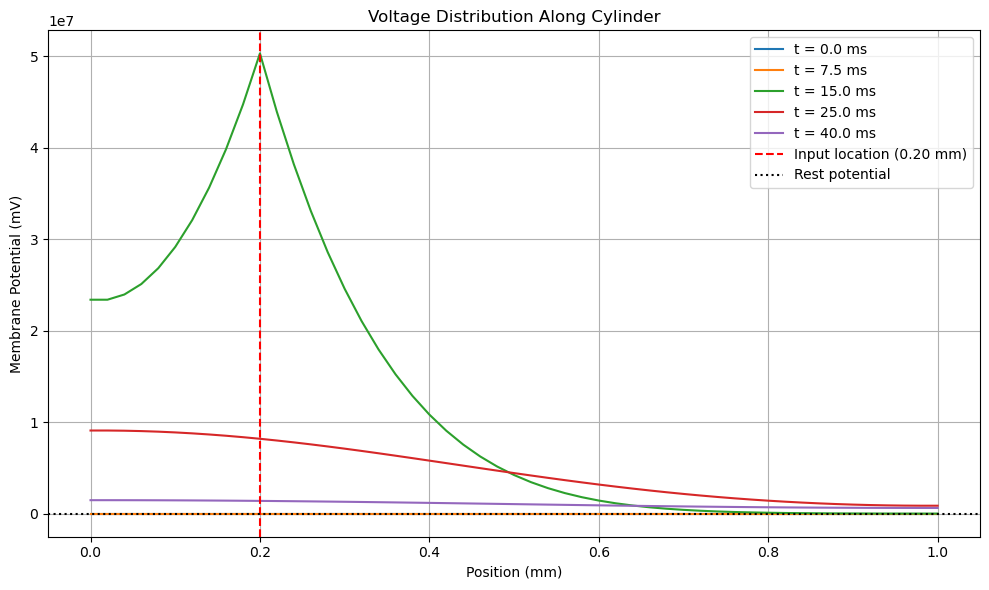

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class EquivalentCylinder:
    def __init__(self, 
                 length=1.0,       # mm
                 diameter=2e-3,    # mm
                 segments=50,
                 Rm=10000,         # Ω·cm²  - specific membrane resistance
                 Ri=100,           # Ω·cm   - intracellular resistivity
                 Cm=1.0,           # μF/cm² - specific membrane capacitance
                 V_rest=-70,       # mV     - resting potential
                 time_steps=None,
                 ):
        # Spatial parameters
        self.length = length        # cylinder length
        self.diameter = diameter    # cylinder diameter
        self.segments = segments    # number of compartments
        self.dx = length / segments # spatial step size
        
        # Electrical parameters
        self.Rm = Rm               # specific membrane resistance
        self.Ri = Ri               # intracellular resistivity
        self.Cm = Cm               # specific membrane capacitance
        self.V_rest = V_rest       # resting potential
        
        # Derived parameters
        self.radius = diameter / 2
        self.lambda_val = np.sqrt((diameter * Rm) / (4 * Ri))  # space constant
        self.tau = Rm * Cm * 1e-3  # membrane time constant (ms)
        
        # Time parameters
        self.time_steps = time_steps
        
    def simulate(self, input_current=None, input_location=0):
        """
        Simulate the equivalent cylinder model.
        
        Parameters:
        - input_current: function of time or array of current values
        - input_location: segment index where current is injected
        
        Returns:
        - voltages: array of shape (time_steps, segments+1)
        """
        dt = self.time_steps[1] - self.time_steps[0]
        num_steps = len(self.time_steps)
        
        # Initialize voltages array [time, position]
        voltages = np.ones((num_steps, self.segments+1)) * self.V_rest
        
        # Set initial condition (all at rest)
        voltages[0, :] = self.V_rest
        
        # Default input current (no input)
        if input_current is None:
            input_current = np.zeros(num_steps)
        elif callable(input_current):
            input_current = np.array([input_current(t) for t in self.time_steps])
        
        # Calculate stability parameters
        alpha = (self.lambda_val**2 * dt) / (self.dx**2 * self.tau)
        
        # Check for numerical stability (CFL condition)
        stability_limit = self.dx**2 / (2 * self.lambda_val**2 / self.tau)
        if dt > stability_limit:
            print(f"Warning: Time step too large for stable simulation.")
            print(f"Current dt = {dt} ms, recommended maximum: {stability_limit:.4f} ms")
        
        # Simulation using forward Euler method
        for t in range(num_steps-1):
            for i in range(1, self.segments):
                # Cable equation in discrete form
                d2V_dx2 = (voltages[t, i+1] - 2*voltages[t, i] + voltages[t, i-1]) / (self.dx**2)
                
                # Update rule with correct time dynamics
                # Voltage change due to spatial diffusion and leakage current
                dV = dt * (
                    (self.lambda_val**2 * d2V_dx2) / self.tau - 
                    (voltages[t, i] - self.V_rest) / self.tau
                )
                
                # Add current at the input location
                if i == input_location:
                    # Convert nA to mV using the conversion factor:
                    # I * R gives voltage where R = Rm/(2*pi*radius*dx)
                    # Using area in cm²
                    area = 2 * np.pi * self.radius * self.dx * 0.1  # Convert mm to cm
                    R_segment = self.Rm / area  # Resistance of the segment in MΩ
                    
                    # Current effect (I*R/C gives voltage change per time)
                    # Scale by dt and proper unit conversion
                    current_effect = input_current[t] * R_segment * dt / (self.tau)
                    dV += current_effect
                    
                voltages[t+1, i] = voltages[t, i] + dV
            
            # Boundary conditions (sealed ends)
            voltages[t+1, 0] = voltages[t+1, 1]       # Left boundary
            voltages[t+1, -1] = voltages[t+1, -2]     # Right boundary
            
        return voltages
    
    def plot_results(self, voltages, input_location=None):
        """
        Plot the simulation results - showing distribution along cylinder.
        
        Parameters:
        - voltages: array of shape (time_steps, segments+1)
        - input_location: segment index where current is injected
        """
        plt.figure(figsize=(10, 6))
        
        # Choose specific times to show the temporal evolution
        # Use different times to better visualize the dynamics
        t_indices = [
            0,  # Start
            int(len(self.time_steps) * 0.15),  # During/just after stimulus
            int(len(self.time_steps) * 0.3),   # Early decay
            int(len(self.time_steps) * 0.5),   # Mid decay
            int(len(self.time_steps) * 0.8),   # Late decay
        ]
        
        for idx, t_idx in enumerate(t_indices):
            if t_idx < len(self.time_steps):
                plt.plot(np.linspace(0, self.length, self.segments+1), 
                         voltages[t_idx], 
                         label=f't = {self.time_steps[t_idx]:.1f} ms')
        
        # Mark input location if provided
        if input_location is not None:
            input_pos = input_location * self.dx
            plt.axvline(x=input_pos, color='r', linestyle='--', 
                       label=f'Input location ({input_pos:.2f} mm)')
            
        plt.axhline(y=self.V_rest, color='k', linestyle=':', label='Rest potential')
        plt.xlabel('Position (mm)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title('Voltage Distribution Along Cylinder')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# Example usage:
import numpy as np
import matplotlib.pyplot as plt

def example_current_pulse(t):
    """Example current input function: brief pulse at t=10ms"""
    if 10 <= t <= 15:
        return 2.0  # nA - increased from 0.5 to get larger response
    return 0

# Set up time steps
t_max = 50  # ms - shortened to focus on dynamics
dt = 0.01    # ms - keeping small time step for stability
time_steps = np.arange(0, t_max, dt)

# Create the cylinder model
cylinder = EquivalentCylinder(
    length=1.0,     # mm
    diameter=0.002, # mm (2 μm)
    segments=50,
    Rm=10000,       # Ω·cm²
    Ri=100,         # Ω·cm
    Cm=1.0,         # μF/cm²
    V_rest=-70,     # mV
    time_steps=time_steps
)

# Simulate with current injection at position 10
voltages = cylinder.simulate(input_current=example_current_pulse, input_location=10)

# Plot the results - distribution along cylinder
cylinder.plot_results(voltages, input_location=10)